In [0]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import requests
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.externals import joblib
from keras.models import load_model

In [0]:
from itertools import islice
def take(n, iterable):
  return list(islice(iterable, n))

In [0]:
# Load scaler and model
scaler = joblib.load("scaler.save")
model = load_model('model.h5')

In [0]:
dic = {'Time stamp':[],'Prediction':[], 'True':[]}

In [0]:
def getLatestThree():
  url = "https://intraday.worldtradingdata.com/api/v1/intraday?symbol=AAPL&interval=1&range=1&api_token=eePBtA45JMcVNCDsem8xwlW3rOvOpac5NRd9EbFKMyGGQvo56VactdAK0a7R"
  response = requests.get(url)
  out = response.json()
  items = take(3,out['intraday'].items())
  closes = [item[1]['close'] for item in items]
  return closes

In [0]:
def prediction():
  closes = getLatestThree()
  dic['True'].append(float(closes[-1]))
  closes = scaler.transform(np.array(closes).reshape(-1,1))
  closes = np.array([closes])
  closes = np.reshape(closes, (closes.shape[0],1,closes.shape[1]))
  pred = scaler.inverse_transform(model.predict(closes))
  d = datetime.today() - timedelta(hours=5)
  t = d.strftime("%H:%M")
  dic['Time stamp'].append(t)
  dic['Prediction'].append(pred[0][0])
  
  df = pd.DataFrame.from_dict(dic)
  df.to_csv('0218_apple_pred_rnn.csv',index=None, header=True)
  print('Prediction of the next minute: ' + str(pred[0][0]))
  return dic

In [0]:
%matplotlib inline
import time
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display

KeyboardInterrupt: ignored

<Figure size 1008x576 with 0 Axes>

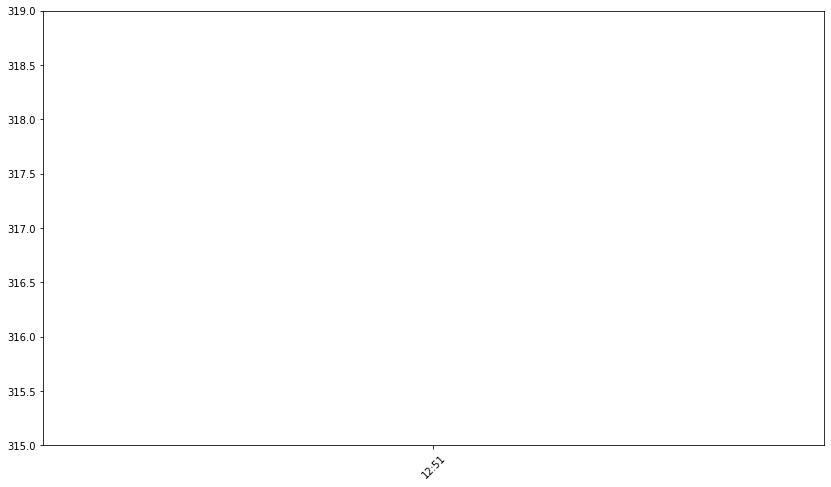

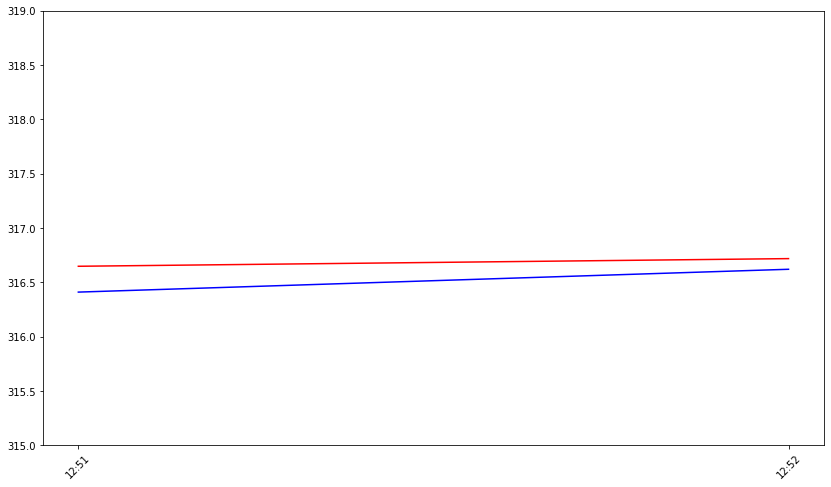

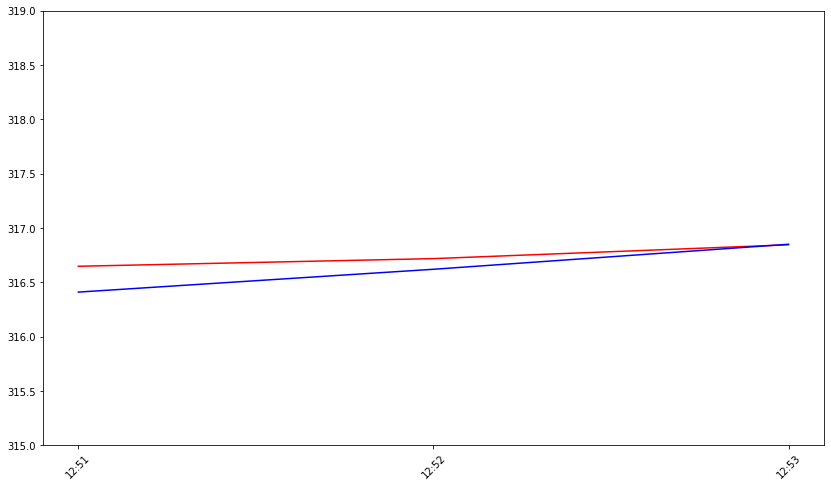

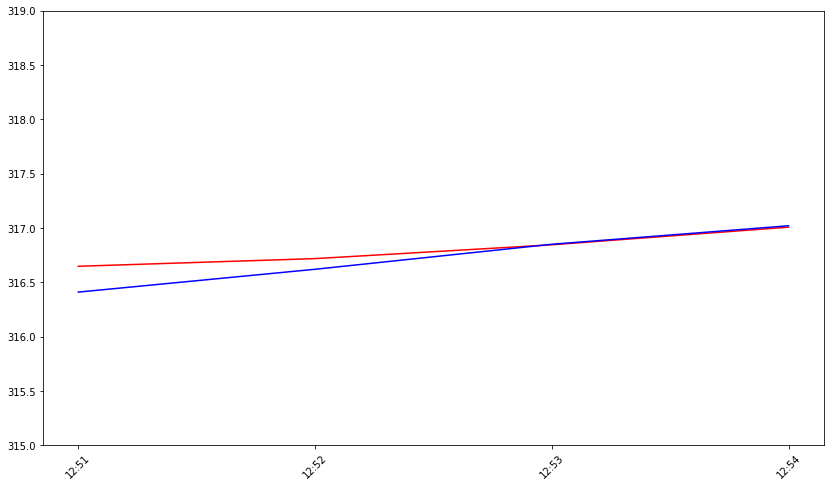

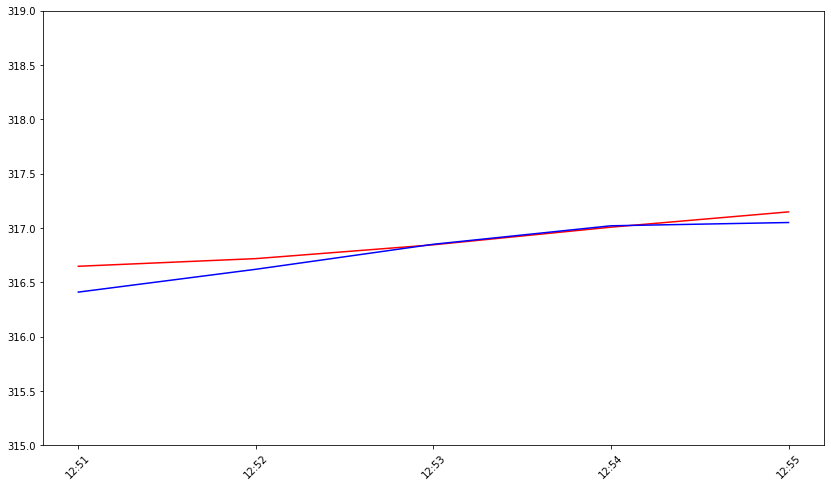

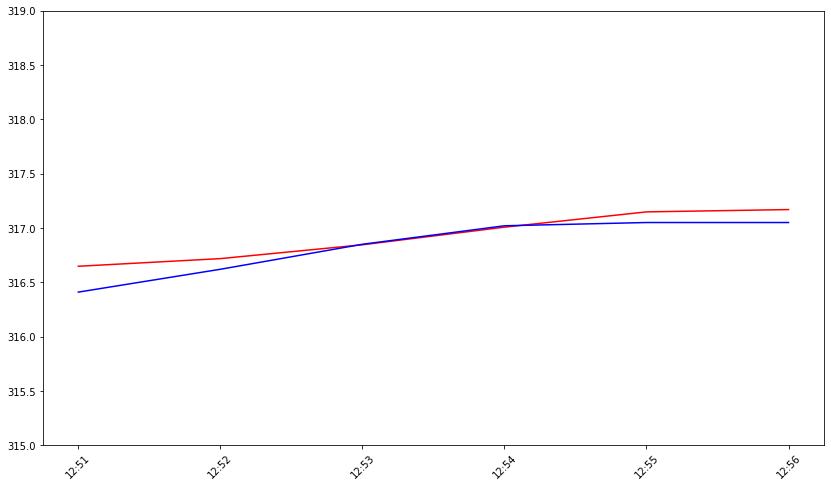

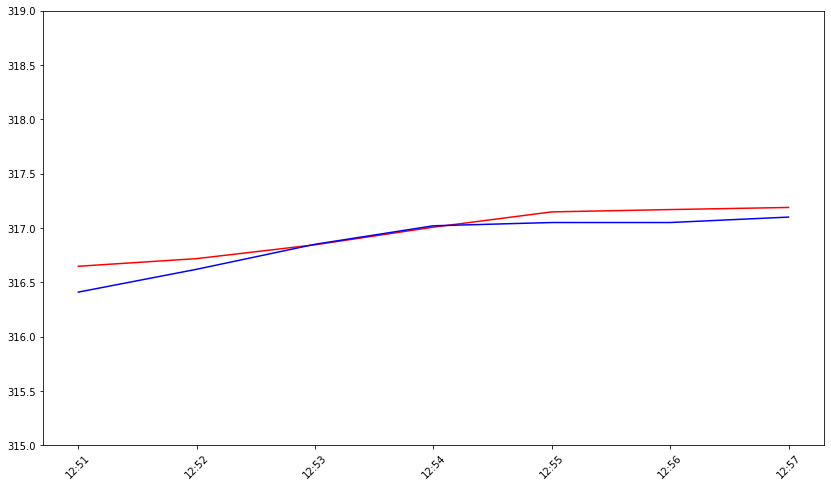

In [36]:
import time
while True:
  dic = prediction()
  plt.figure(figsize=(14, 8))
  if (len(dic['Prediction'])> 1):
    plt.plot(dic['Time stamp'][:-1],dic['Prediction'][:-1],'-r',label='Predicted Close')
    plt.plot(dic['Time stamp'][:-1],dic['True'][1:],'-b', label='True Close')
    plt.xticks(rotation = 45)
    plt.ylim(315, 319)
    display.display(plt.gcf())
    display.clear_output(wait=True)
  time.sleep(60)